# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 14.0 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 13.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 21.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 4.1 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp11 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [9]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [10]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [11]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5243316,-77.7727608,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [12]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Sun Nov 22 00:22:29 +0000 2020'
'Sun Nov 22 00:22:22 +0000 2020'
'Sun Nov 22 00:22:00 +0000 2020'
'Sun Nov 22 00:21:51 +0000 2020'
'Sun Nov 22 00:21:39 +0000 2020'
'Sun Nov 22 00:21:28 +0000 2020'
'Sun Nov 22 00:21:11 +0000 2020'
'Sun Nov 22 00:20:52 +0000 2020'
'Sun Nov 22 00:20:42 +0000 2020'
'Sun Nov 22 00:20:32 +0000 2020'
'Sun Nov 22 00:20:30 +0000 2020'
'Sun Nov 22 00:19:43 +0000 2020'
'Sun Nov 22 00:19:33 +0000 2020'
'Sun Nov 22 00:19:17 +0000 2020'
'Sun Nov 22 00:19:16 +0000 2020'
'Sun Nov 22 00:19:04 +0000 2020'
'Sun Nov 22 00:17:07 +0000 2020'
'Sun Nov 22 00:16:56 +0000 2020'
'Sun Nov 22 00:16:34 +0000 2020'
'Sun Nov 22 00:16:26 +0000 2020'
'Sun Nov 22 00:16:05 +0000 2020'
'Sun Nov 22 00:15:24 +0000 2020'
'Sun Nov 22 00:15:06 +0000 2020'
'Sun Nov 22 00:14:13 +0000 2020'
'Sun Nov 22 00:13:50 +0000 2020'
'Sun Nov 22 00:13:48 +0000 2020'
'Sun Nov 22 00:13:14 +0000 2020'
'Sun Nov 22 00:13:11 +0000 2020'
'Sun Nov 22 00:12:45 +0000 2020'
'Sun Nov 22 00:12:37 +0000 2020'
'Sun Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [13]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Sat Nov 21 23:45:37 +0000 2020'
'Sat Nov 21 23:45:32 +0000 2020'
'Sat Nov 21 23:45:02 +0000 2020'
'Sat Nov 21 23:43:57 +0000 2020'
'Sat Nov 21 23:43:23 +0000 2020'
'Sat Nov 21 23:43:02 +0000 2020'
'Sat Nov 21 23:42:53 +0000 2020'
'Sat Nov 21 23:42:37 +0000 2020'
'Sat Nov 21 23:42:31 +0000 2020'
'Sat Nov 21 23:42:11 +0000 2020'
'Sat Nov 21 23:42:10 +0000 2020'
'Sat Nov 21 23:42:10 +0000 2020'
'Sat Nov 21 23:41:32 +0000 2020'
'Sat Nov 21 23:41:32 +0000 2020'
'Sat Nov 21 23:41:28 +0000 2020'
'Sat Nov 21 23:41:17 +0000 2020'
'Sat Nov 21 23:41:09 +0000 2020'
'Sat Nov 21 23:40:51 +0000 2020'
'Sat Nov 21 23:40:30 +0000 2020'
'Sat Nov 21 23:40:20 +0000 2020'
'Sat Nov 21 23:40:15 +0000 2020'
'Sat Nov 21 23:40:07 +0000 2020'
'Sat Nov 21 23:39:48 +0000 2020'
'Sat Nov 21 23:39:23 +0000 2020'
'Sat Nov 21 23:39:02 +0000 2020'
'Sat Nov 21 23:38:53 +0000 2020'
'Sat Nov 21 23:38:44 +0000 2020'
'Sat Nov 21 23:37:52 +0000 2020'
'Sat Nov 21 23:37:40 +0000 2020'
'Sat Nov 21 23:37:37 +0000 2020'
'Sat Nov 2

'Sat Nov 21 22:24:33 +0000 2020'
'Sat Nov 21 22:23:56 +0000 2020'
'Sat Nov 21 22:23:41 +0000 2020'
'Sat Nov 21 22:23:40 +0000 2020'
'Sat Nov 21 22:23:12 +0000 2020'
'Sat Nov 21 22:23:07 +0000 2020'
'Sat Nov 21 22:23:04 +0000 2020'
'Sat Nov 21 22:21:58 +0000 2020'
'Sat Nov 21 22:21:44 +0000 2020'
'Sat Nov 21 22:21:40 +0000 2020'
'Sat Nov 21 22:21:39 +0000 2020'
'Sat Nov 21 22:21:35 +0000 2020'
'Sat Nov 21 22:21:22 +0000 2020'
'Sat Nov 21 22:21:18 +0000 2020'
'Sat Nov 21 22:21:07 +0000 2020'
'Sat Nov 21 22:21:01 +0000 2020'
'Sat Nov 21 22:20:50 +0000 2020'
'Sat Nov 21 22:20:49 +0000 2020'
'Sat Nov 21 22:20:45 +0000 2020'
'Sat Nov 21 22:20:42 +0000 2020'
'Sat Nov 21 22:20:35 +0000 2020'
'Sat Nov 21 22:20:17 +0000 2020'
'Sat Nov 21 22:20:04 +0000 2020'
'Sat Nov 21 22:19:46 +0000 2020'
'Sat Nov 21 22:19:17 +0000 2020'
'Sat Nov 21 22:18:22 +0000 2020'
'Sat Nov 21 22:18:09 +0000 2020'
'Sat Nov 21 22:17:53 +0000 2020'
'Sat Nov 21 22:17:47 +0000 2020'
'Sat Nov 21 22:17:44 +0000 2020'
'Sat Nov 2

'Sat Nov 21 21:23:25 +0000 2020'
'Sat Nov 21 21:23:24 +0000 2020'
'Sat Nov 21 21:23:20 +0000 2020'
'Sat Nov 21 21:23:20 +0000 2020'
'Sat Nov 21 21:23:19 +0000 2020'
'Sat Nov 21 21:23:12 +0000 2020'
'Sat Nov 21 21:23:12 +0000 2020'
'Sat Nov 21 21:23:09 +0000 2020'
'Sat Nov 21 21:23:04 +0000 2020'
'Sat Nov 21 21:22:49 +0000 2020'
'Sat Nov 21 21:22:47 +0000 2020'
'Sat Nov 21 21:22:36 +0000 2020'
'Sat Nov 21 21:22:31 +0000 2020'
'Sat Nov 21 21:22:11 +0000 2020'
'Sat Nov 21 21:22:11 +0000 2020'
'Sat Nov 21 21:22:09 +0000 2020'
'Sat Nov 21 21:22:07 +0000 2020'
'Sat Nov 21 21:22:00 +0000 2020'
'Sat Nov 21 21:21:56 +0000 2020'
'Sat Nov 21 21:21:50 +0000 2020'
'Sat Nov 21 21:21:47 +0000 2020'
'Sat Nov 21 21:21:41 +0000 2020'
'Sat Nov 21 21:21:32 +0000 2020'
'Sat Nov 21 21:21:29 +0000 2020'
'Sat Nov 21 21:21:25 +0000 2020'
'Sat Nov 21 21:20:58 +0000 2020'
'Sat Nov 21 21:20:42 +0000 2020'
'Sat Nov 21 21:20:37 +0000 2020'
'Sat Nov 21 21:20:19 +0000 2020'
'Sat Nov 21 21:20:14 +0000 2020'
'Sat Nov 2

'Sat Nov 21 20:22:30 +0000 2020'
'Sat Nov 21 20:22:05 +0000 2020'
'Sat Nov 21 20:22:05 +0000 2020'
'Sat Nov 21 20:21:59 +0000 2020'
'Sat Nov 21 20:21:58 +0000 2020'
'Sat Nov 21 20:21:13 +0000 2020'
'Sat Nov 21 20:21:00 +0000 2020'
'Sat Nov 21 20:20:55 +0000 2020'
'Sat Nov 21 20:20:39 +0000 2020'
'Sat Nov 21 20:20:18 +0000 2020'
'Sat Nov 21 20:20:09 +0000 2020'
'Sat Nov 21 20:19:41 +0000 2020'
'Sat Nov 21 20:19:02 +0000 2020'
'Sat Nov 21 20:18:58 +0000 2020'
'Sat Nov 21 20:18:51 +0000 2020'
'Sat Nov 21 20:18:36 +0000 2020'
'Sat Nov 21 20:18:27 +0000 2020'
'Sat Nov 21 20:18:08 +0000 2020'
'Sat Nov 21 20:17:57 +0000 2020'
'Sat Nov 21 20:17:56 +0000 2020'
'Sat Nov 21 20:17:45 +0000 2020'
'Sat Nov 21 20:17:36 +0000 2020'
'Sat Nov 21 20:17:34 +0000 2020'
'Sat Nov 21 20:17:32 +0000 2020'
'Sat Nov 21 20:17:15 +0000 2020'
'Sat Nov 21 20:17:04 +0000 2020'
'Sat Nov 21 20:17:03 +0000 2020'
'Sat Nov 21 20:16:57 +0000 2020'
'Sat Nov 21 20:16:54 +0000 2020'
'Sat Nov 21 20:16:54 +0000 2020'
'Sat Nov 2

'Sat Nov 21 19:16:03 +0000 2020'
'Sat Nov 21 19:16:00 +0000 2020'
'Sat Nov 21 19:15:42 +0000 2020'
'Sat Nov 21 19:15:36 +0000 2020'
'Sat Nov 21 19:15:08 +0000 2020'
'Sat Nov 21 19:14:51 +0000 2020'
'Sat Nov 21 19:14:46 +0000 2020'
'Sat Nov 21 19:14:14 +0000 2020'
'Sat Nov 21 19:13:47 +0000 2020'
'Sat Nov 21 19:13:38 +0000 2020'
'Sat Nov 21 19:13:37 +0000 2020'
'Sat Nov 21 19:13:30 +0000 2020'
'Sat Nov 21 19:13:01 +0000 2020'
'Sat Nov 21 19:12:41 +0000 2020'
'Sat Nov 21 19:12:30 +0000 2020'
'Sat Nov 21 19:12:09 +0000 2020'
'Sat Nov 21 19:12:02 +0000 2020'
'Sat Nov 21 19:11:36 +0000 2020'
'Sat Nov 21 19:11:20 +0000 2020'
'Sat Nov 21 19:10:40 +0000 2020'
'Sat Nov 21 19:10:37 +0000 2020'
'Sat Nov 21 19:10:36 +0000 2020'
'Sat Nov 21 19:10:29 +0000 2020'
'Sat Nov 21 19:10:12 +0000 2020'
'Sat Nov 21 19:10:07 +0000 2020'
'Sat Nov 21 19:10:00 +0000 2020'
'Sat Nov 21 19:09:46 +0000 2020'
'Sat Nov 21 19:09:45 +0000 2020'
'Sat Nov 21 19:09:41 +0000 2020'
'Sat Nov 21 19:09:34 +0000 2020'
'Sat Nov 2

'Sat Nov 21 18:30:00 +0000 2020'
'Sat Nov 21 18:30:00 +0000 2020'
'Sat Nov 21 18:29:57 +0000 2020'
'Sat Nov 21 18:29:50 +0000 2020'
'Sat Nov 21 18:29:39 +0000 2020'
'Sat Nov 21 18:29:21 +0000 2020'
'Sat Nov 21 18:29:20 +0000 2020'
'Sat Nov 21 18:29:19 +0000 2020'
'Sat Nov 21 18:28:41 +0000 2020'
'Sat Nov 21 18:28:18 +0000 2020'
'Sat Nov 21 18:28:11 +0000 2020'
'Sat Nov 21 18:28:04 +0000 2020'
'Sat Nov 21 18:28:02 +0000 2020'
'Sat Nov 21 18:27:40 +0000 2020'
'Sat Nov 21 18:27:18 +0000 2020'
'Sat Nov 21 18:26:46 +0000 2020'
'Sat Nov 21 18:26:45 +0000 2020'
'Sat Nov 21 18:26:42 +0000 2020'
'Sat Nov 21 18:26:14 +0000 2020'
'Sat Nov 21 18:26:05 +0000 2020'
'Sat Nov 21 18:25:59 +0000 2020'
'Sat Nov 21 18:25:45 +0000 2020'
'Sat Nov 21 18:25:35 +0000 2020'
'Sat Nov 21 18:25:23 +0000 2020'
'Sat Nov 21 18:25:09 +0000 2020'
'Sat Nov 21 18:24:54 +0000 2020'
'Sat Nov 21 18:24:31 +0000 2020'
'Sat Nov 21 18:24:31 +0000 2020'
'Sat Nov 21 18:24:22 +0000 2020'
'Sat Nov 21 18:24:19 +0000 2020'
'Sat Nov 2

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [14]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1610
1417


Create a text index and print the Tweets containing specific keywords. 

In [15]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [16]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [17]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: WR
text: #FreeSpeech #FreedomOfSpeech @SpeechUnion #YeadonUnlocked #IamYeadon #COVID19 #COVID19
----
name: Darth Maul's Anger
text: issue because it only takes one person to get many people sick. 

#covid #covid19 #COVID #COVID19
----
name: Sara Naheedy
text: RT @stloiyf: #COVID19
----
name: On Demand Escrow
text: RT @stloiyf: #COVID19
----
name: FratTrashUNC
text: Do.
Not.
Travel.
This.
Thanks-
giving.
#COVID19
----
name: ✨ok sorry✨
text: Those who have had #covid19 and experienced confusion, what was that like?
----
name: pegparenting
text: #COVID19 https://t.co/I9Cn3ptFx0
----
name: Sara Naheedy Law ⚖️
text: RT @stloiyf: Heartbreaking 💔 #COVID19
----
name: ASE RAY OF LIGHT
text: #COVID19 https://t.co/uKFR04IbSp
----
name: Erin Snider🆘️ 🇺🇸 🦋🌍🌊
text: @StephenKing @PatriciaRork #COVID19 reality. 🤨


In [18]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [19]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,possibly_sensitive,extended_entities
0,5fb9afcbb60b991ffca6db50,Sat Nov 21 20:10:35 +0000 2020,1330242225205338114,1330242225205338114,#FreeSpeech #FreedomOfSpeech @SpeechUnion #Yea...,False,"{'hashtags': [{'text': 'FreeSpeech', 'indices'...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.330242e+18,...,0,False,False,und,NaN,NaN,NaN,NaN,NaN,NaN
1,5fb9afd1b60b991ffca6dd4d,Sat Nov 21 18:26:46 +0000 2020,1330216095584808960,1330216095584808960,issue because it only takes one person to get ...,False,"{'hashtags': [{'text': 'covid', 'indices': [66...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.330216e+18,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
2,5fb9afcab60b991ffca6dafa,Sat Nov 21 20:30:31 +0000 2020,1330247239567077382,1330247239567077382,RT @stloiyf: #COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,und,{'created_at': 'Sat Nov 21 20:29:42 +0000 2020...,1.330158e+18,1330158481438109697,NaN,NaN,NaN
3,5fb9afcab60b991ffca6daea,Sat Nov 21 20:35:13 +0000 2020,1330248424822874113,1330248424822874113,RT @stloiyf: #COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,und,{'created_at': 'Sat Nov 21 20:29:42 +0000 2020...,1.330158e+18,1330158481438109697,NaN,NaN,NaN
4,5fb9afceb60b991ffca6dc44,Sat Nov 21 19:10:12 +0000 2020,1330227026029109251,1330227026029109251,Do.\nNot.\nTravel.\nThis.\nThanks-\ngiving.\n#...,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
5,5fb9afc3b60b991ffca6d83c,Sat Nov 21 23:34:36 +0000 2020,1330293565495369737,1330293565495369737,Those who have had #covid19 and experienced co...,False,"{'hashtags': [{'text': 'covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
6,5fb9afd1b60b991ffca6dda2,Sat Nov 21 18:13:12 +0000 2020,1330212684088942602,1330212684088942602,#COVID19 https://t.co/I9Cn3ptFx0,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,und,NaN,1.330202e+18,1330201599734673409,{'created_at': 'Sat Nov 21 17:29:09 +0000 2020...,False,NaN
7,5fb9afccb60b991ffca6db92,Sat Nov 21 19:54:28 +0000 2020,1330238166272512002,1330238166272512002,RT @stloiyf: Heartbreaking 💔 #COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,en,{'created_at': 'Sat Nov 21 19:53:59 +0000 2020...,1.330163e+18,1330163367055683586,NaN,NaN,NaN
8,5fb9afccb60b991ffca6db8b,Sat Nov 21 19:56:41 +0000 2020,1330238726019178496,1330238726019178496,#COVID19 https://t.co/uKFR04IbSp,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,und,NaN,1.330236e+18,1330235913352458241,{'created_at': 'Sat Nov 21 19:45:30 +0000 2020...,False,NaN
9,5fb9afcbb60b991ffca6db4e,Sat Nov 21 20:10:47 +0000 2020,1330242274723295233,1330242274723295233,@StephenKing @PatriciaRork #COVID19 reality. 🤨,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en'

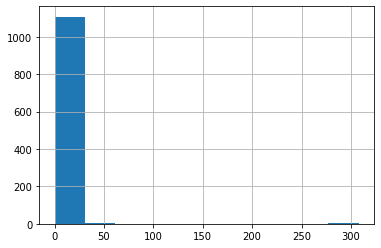

In [20]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count